In [2]:
import re
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Get data

In [21]:
dataset_filename1 = "../../preprocessing/data/processed_merge.csv"
dataset_filename2 = "../../linguistic_model/data/synthetic_clan_merge_c4.csv"

df1 = pd.read_csv(dataset_filename1, encoding='utf8', index_col=False)
df1 = df1.loc[df1['label']==1]
df2 = pd.read_csv(dataset_filename2, encoding='utf8', index_col=False)
df2 = df2.loc[df2['label']==1]

In [22]:
df1.head()

,Unnamed: 0.1,Unnamed: 0,scenario,source_file,original_text,preprocessed_text,label
1,1,785,Stroke,adler25a.cha,and I &+b brimɛmbə˞@u [: remember] [* p:n] osp...,and i remember hospital hospital.,1
5,5,4197,Window,1008-LARC.cha,and he [/] &-uh he got it &+m mom [//] father ...,and he he got it mom father.,1
6,6,13335,Window,UNH04a.cha,no . 263365_263455,no.,1
8,8,1494,Cinderella,elman03a.cha,&-uh Cinderella &-uh beautiful . [+ gram] 153...,cinderella beautiful.,1
9,9,14262,Stroke,UNH17a.cha,I don't remember . 229025_229905,i don't remember.,1


In [23]:
df2.head()

,modified,label
1,bridging and.,1
3,we collect interned and for you.,1
4,has your.,1
8,us is and.,1
12,to.,1


In [24]:
# no null values 
df1.isnull().sum()

Unnamed: 0.1         0
Unnamed: 0           0
scenario             0
source_file          0
original_text        0
preprocessed_text    0
label                0
dtype: int64

In [25]:
df2.isnull().sum()

modified    0
label       0
dtype: int64

In [26]:
# switch the labels (0 for real data, 1 for fake data)
df1["label"] = 0
df2["label"] = 1

df1 = df1.rename(columns={'preprocessed_text': 'modified'})
df1 = df1.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "scenario", "source_file", "original_text"], axis=1)

In [27]:
df1.head()

,modified,label
1,and i remember hospital hospital.,0
5,and he he got it mom father.,0
6,no.,0
8,cinderella beautiful.,0
9,i don't remember.,0


In [28]:
df2.head()

,modified,label
1,bridging and.,1
3,we collect interned and for you.,1
4,has your.,1
8,us is and.,1
12,to.,1


In [29]:
df = pd.concat([df1, df2], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [30]:
df

,modified,label
0,umbrella.,0
1,and then i i watch them together.,0
2,"and, either to or customers.",1
3,get and your.,1
4,yourself.,1
...,...,...
33840,they said.,0
33841,who pizarro.,1
33842,fire and ladder and kitty soon.,0
33843,and she says.,0


In [32]:
sentences = df["modified"]

<Axes: xlabel='label', ylabel='count'>

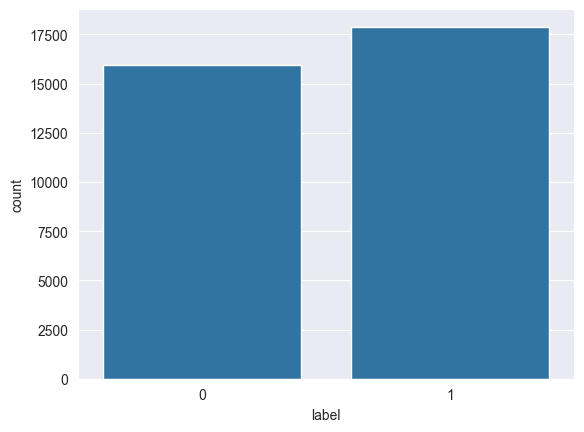

In [33]:
sns.countplot(x="label",data=df)

In [34]:
input_df = df

In [35]:
input_df

,modified,label
0,umbrella.,0
1,and then i i watch them together.,0
2,"and, either to or customers.",1
3,get and your.,1
4,yourself.,1
...,...,...
33840,they said.,0
33841,who pizarro.,1
33842,fire and ladder and kitty soon.,0
33843,and she says.,0


# Encoding # 1

In [36]:
import multiprocessing
from gensim.models import Word2Vec

In [37]:
cores = multiprocessing.cpu_count()
cores

16

In [39]:
words_in_sentences=[]
for i in input_df["modified"]:
    words_in_sentences.append(re.findall(r"[\w']+|[.,!?;]", i.lower()))
words_in_sentences[20]

['yeah', 'mhm', 'yeah', '.']

In [40]:
input_df.iloc[20]

modified    yeah mhm yeah.
label                    0
Name: 20, dtype: object

In [41]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size = 300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-10)

In [42]:
w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [43]:
w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(1135933, 4453920)

In [44]:
w2v_model.save("word2vec_data.model")

In [45]:
w2v_model = Word2Vec.load("word2vec_data.model")

In [46]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

9591


In [47]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [48]:
transformed_text, labels1= avg_w2vec(input_df["modified"], input_df["label"])

# Model fitting

In [49]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20, random_state=42)

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
# odd k for preventing ties
grid_params = { 'n_neighbors' : [3, 5, 7, 9, 11],
               'metric' : ['manhattan', 'minkowski', 'cosine']}

In [51]:
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, grid_params, n_jobs=10, verbose=1, return_train_score=True)
clf.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'metric': ['manhattan', 'minkowski', 'cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             return_train_score=True, verbose=1)

In [52]:
result_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
                       pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["mean_test_acc"]),
                       pd.DataFrame(clf.cv_results_["mean_train_score"], columns=["mean_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_train_score"], columns=["std_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_test_score"], columns=["std_test_acc"])], axis=1)

In [53]:
result_df.to_csv("knn-data-results.csv")

In [54]:
clf.best_params_

{'metric': 'minkowski', 'n_neighbors': 7}

In [55]:
clf.cv_results_ 

{'mean_fit_time': array([0.08867383, 0.08887377, 0.03424015, 0.02760267, 0.02623487,
        0.02951565, 0.03356714, 0.02943735, 0.03063893, 0.02950988,
        0.04375901, 0.04033933, 0.03262911, 0.04019232, 0.04019685]),
 'std_fit_time': array([0.00178809, 0.00171988, 0.00392303, 0.00102065, 0.00125475,
        0.00184902, 0.00147036, 0.0010369 , 0.00172714, 0.00194994,
        0.01119206, 0.00953231, 0.00320388, 0.0091336 , 0.00272834]),
 'mean_score_time': array([13.11938591, 13.11820664, 13.72748623, 13.67758164, 13.80829201,
         1.01494732,  1.13401804,  0.98737669,  1.15381055,  1.16680045,
         2.25191584,  1.91210961,  1.79925704,  1.80107431,  2.72596817]),
 'std_score_time': array([0.05564922, 0.06516265, 0.03686451, 0.08815446, 0.08454867,
        0.04094469, 0.03269323, 0.04286008, 0.01574421, 0.04332802,
        0.09630348, 0.06325502, 0.03603033, 0.03480944, 0.03540544]),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
   

In [56]:
knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'], metric=clf.best_params_['metric'])
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [57]:
knnPickle = open('data_pickle', 'wb')
pickle.dump(knn, knnPickle)
knnPickle.close()

# Training + testing plots

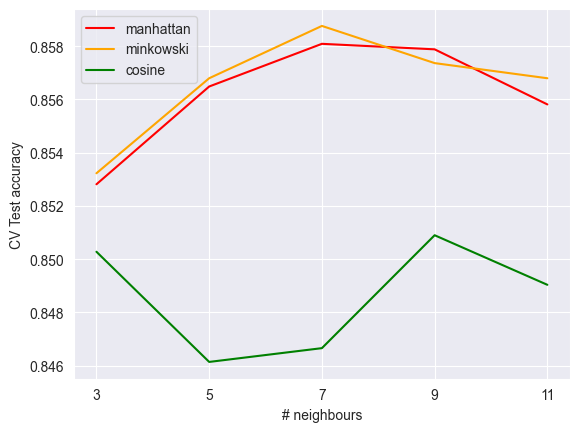

In [58]:
import matplotlib.pyplot as plt

result_df = pd.read_csv("knn-data-results.csv", encoding="utf-8")
cols = ['red', 'orange', 'green']
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_test_acc, color=col, label=metric)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

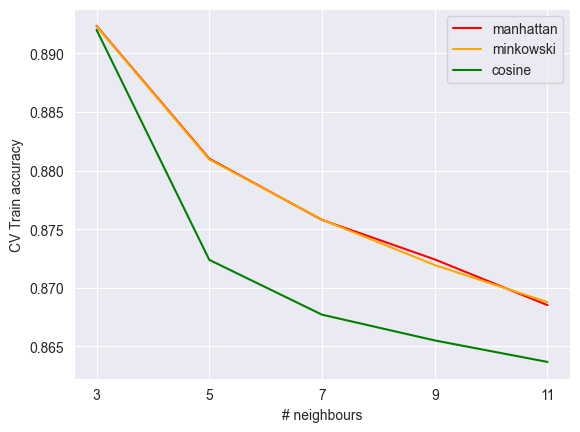

In [59]:
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc, color=col, label=metric)
    # plt.fill_between(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc - result_df[result_df.metric == metric].std_train_acc,result_df[result_df.metric == metric].mean_train_acc + result_df[result_df.metric == metric].std_train_acc)

plt.xlabel("# neighbours")
plt.ylabel("CV Train accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

# Evaluation

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [61]:
# loaded_model = pickle.load(open('../models/knn_pickle', 'rb'))
loaded_model = pickle.load(open('data_pickle', 'rb'))

In [62]:
loaded_model

KNeighborsClassifier(n_neighbors=7)

In [63]:
result = loaded_model.predict(x_test)

In [64]:
len(x_test)

4834

In [65]:
len(y_test)

4834

In [66]:
print(accuracy_score(y_test, result))

0.8630533719486967


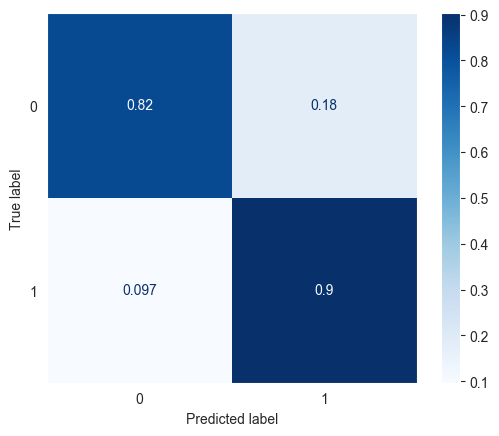

In [67]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [68]:
print(tn, fn, tp, fp)

0.8192041522491349 0.09674861221252974 0.9032513877874703 0.18079584775086505


In [69]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.8332214300043096
0.9032513877874703
0.8668242949437269
